<a href="https://colab.research.google.com/github/sana-kabbani/PD_Classification/blob/main/DistilHubert_audio_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def encode_batch(feature_extractor, images, batch_size=10):
    encodings = {key: [] for key in feature_extractor.model_input_names}
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch_encodings = feature_extractor(batch, sampling_rate=16000, padding=True ,return_tensors="pt")
        for key in encodings:
            encodings[key].extend(batch_encodings[key])
    return {key: torch.stack(values) for key, values in encodings.items()}

In [ ]:
import torch

encodings = encode_batch(feature_extractor, list(df["audio"]))

In [ ]:
full_dataset = Dataset_audio(encodings, list(df["label"]))


In [ ]:
torch.save(full_dataset, '/content/drive/MyDrive/Data/audio_dataset.pt')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture

!pip install evaluate

## 1. General Preparation

Import some common libraries.

In [ ]:
import time
import torch
from tqdm.notebook import tqdm


Use GPU Facilities.

In [ ]:
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

GPU is available. 
Using GPU


In [ ]:
import pandas as pd
import pickle
with open('/content/drive/MyDrive/Data/data_array.pkl', 'rb') as f:
    df = pickle.load(f)

## 2. Data Processing

In [ ]:
# RAV_df = RAV_df.sample(frac=0.1)
# train_df = df.sample(frac=0.7)
# test_df = df.drop(train_df.index)

Let's have a look at the training data.

In [ ]:
# train_df

In [ ]:
# # test_df["label"].value_counts()

label
0    354
1    322
Name: count, dtype: int64

In [ ]:
from transformers import AutoFeatureExtractor
from transformers import AutoModelForAudioClassification
from transformers import TrainingArguments
from transformers import Trainer


In [ ]:
from datasets import Dataset
import librosa




# train_data = Dataset.from_pandas(train_df)
# test_data = Dataset.from_pandas(test_df)

model = "ntu-spml/distilhubert"

# Instantiating feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model, do_normalize = True, return_attention_mask = True)
# train_encodings = feature_extractor(list(train_data["audio"]), sampling_rate=16000, padding=True, return_tensors="pt")
# test_encodings = feature_extractor(list(test_data["audio"]), sampling_rate=16000, padding=True, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

### 2.2 Tokenization

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [ ]:
class Dataset_audio(torch.utils.data.Dataset):
    def __init__(self, encodings, label):
        self.encodings = encodings


        self.label = label

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.label[idx])
        return item

    def __len__(self):
        return len(self.label)


# train_dataset = Dataset(train_encodings, list(train_data["label"]))
# test_dataset = Dataset(test_encodings, list(test_data["label"]))

## 3. Loading the Model and Optimizer

In [ ]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading the model
model = AutoModelForAudioClassification.from_pretrained(model,
                                                         num_labels = 2,
                                                       )
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5,    eps=1e-8
)

config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.0M [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from sklearn.metrics import f1_score
def f1_score_func(preds, labels):
  preds_flat = np.argmax(preds , axis = 1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat , preds_flat , average  ='weighted')

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def accuracy_per_class(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    acc_per_class = {}

    for label in np.unique(labels_flat):
        TP = np.sum((preds_flat == label) & (labels_flat == label))
        FP = np.sum((preds_flat == label) & (labels_flat != label))
        TN = np.sum((preds_flat != label) & (labels_flat != label))
        FN = np.sum((preds_flat != label) & (labels_flat == label))

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        acc_per_class[label] = {
            'accuracy': (TP + TN) / (TP + FP + TN + FN),
            'sensitivity': sensitivity,
            'specificity': specificity,
            'f1_score': f1_score(labels_flat, preds_flat, labels=[label], average='binary')
        }
    return acc_per_class



## 4. Training

Prepare some utility functions.

In [ ]:
from torch.utils.data import DataLoader

from transformers import get_linear_schedule_with_warmup



In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:



import numpy as np
from sklearn.metrics import classification_report


def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        with torch.no_grad():

            loss = outputs.loss
            logits = outputs.logits
            loss_val_total += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = labels.cpu().numpy()
            predictions.append(logits)
            true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)


    return loss_val_avg, predictions, true_vals

In [ ]:
df = torch.load('/content/drive/MyDrive/Data/audio_dataset.pt')


Train the model.

In [ ]:
loss_values = []
val_loss_values = []
training_times = []
testing_times = []
hist = []
import time
from datasets import Dataset

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

kf = KFold(n_splits=4, shuffle=True, random_state=42)
fold = 0
patience = 10
from jax._src import config
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report , confusion_matrix
epochs = 6



hist = [{} for _ in range(epochs) ]
for train_idx, test_idx in kf.split(df):
    fold += 1
    print(f"Fold #{fold}")
    train_dataset = torch.utils.data.Subset(dd, train_idx)
    test_dataset = torch.utils.data.Subset(dd, test_idx)
    dataloader_train = DataLoader(train_dataset, batch_size=10, shuffle=True)
    dataloader_val = DataLoader(test_dataset, batch_size=10, shuffle=True)
    scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps = 0,
    num_training_steps = len(dataloader_train)*epochs
)



    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        loss_train_total = 0
        progress_bar = tqdm(dataloader_train
                            , desc='Epoch{:1d}'.format(epoch)
                            , leave=False,
                            disable = False)
        start_time = time.time()


        for batch in progress_bar:

          model.zero_grad()
          input_ids = batch['input_values'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)
          outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs['loss']
          loss_train_total += loss.item()


          loss.backward()
          loss_values.append(loss.item()/len(batch))

          torch.nn.utils.clip_grad_norm_(model.parameters() , 1.0)

          optim.step()
          scheduler.step()

          progress_bar.set_postfix({'training_loss' : '{:.3f}'.format(loss.item()/len(batch)
          )})
        end_time = time.time()
        train_time = end_time - start_time
        training_times.append(train_time)


      # torch.save(model.state_dict() , f'/content/drive/MyDrive/models/Distilbert{epoch}.model')
        tqdm.write(f'\nEpoch {epoch}')
        val_loss , predictions , true_vals = evaluate(dataloader_val)
        val_loss_values.append(val_loss)

        print(f'Validation loss: {val_loss}')

        # Calculate validation metrics
        class_predictions = np.argmax(predictions, axis=1)
        confusion = confusion_matrix(true_vals, class_predictions)

        report = classification_report(true_vals, class_predictions)
        accuracy = accuracy_per_class(predictions , true_vals)

        print(f'train_time:\n{train_time}')
        print(f'Validation metrics:\n{report}')
        print(f'accuracy:\n{accuracy[0].get("accuracy")}')
        print(f'sensitivity:\n{accuracy[0].get("sensitivity")}')
        print(f'specificity:\n{accuracy[0].get("specificity")}')




        tqdm.write(f'Confusion matrix:\n{confusion}')
        end_time = time.time()
        test_time = end_time - start_time
        testing_times.append(test_time)
        print(f'test_time:\n{test_time}')

        hist.append({
            "Fold" : fold,
            'epochIndex': epoch,
            'loss': loss.item(),
            'val_loss': val_loss,
            'classification_report': report,
            'conf_matrix': confusion,
            'accuracy': accuracy[0].get("accuracy"),
            'sensitivity': accuracy[0].get("sensitivity"),
            'specificity':accuracy[0].get("specificity"),
        })


Fold #1


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch1:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 1
Validation loss: 0.05976892674439832
train_time:
52.02830767631531
Validation metrics:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       298
           1       1.00      0.98      0.99       265

    accuracy                           0.99       563
   macro avg       0.99      0.99      0.99       563
weighted avg       0.99      0.99      0.99       563

accuracy:
0.9893428063943162
sensitivity:
0.9966442953020134
specificity:
0.9811320754716981
Confusion matrix:
[[297   1]
 [  5 260]]
test_time:
56.50371551513672


Epoch2:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 2
Validation loss: 0.01908885068341828
train_time:
50.48055386543274
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       298
           1       1.00      1.00      1.00       265

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
0.9982238010657194
sensitivity:
0.9966442953020134
specificity:
1.0
Confusion matrix:
[[297   1]
 [  0 265]]
test_time:
55.087722301483154


Epoch3:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 3
Validation loss: 0.01726340704287092
train_time:
52.77526497840881
Validation metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       298
           1       1.00      0.99      0.99       265

    accuracy                           0.99       563
   macro avg       0.99      0.99      0.99       563
weighted avg       0.99      0.99      0.99       563

accuracy:
0.9946714031971581
sensitivity:
0.9966442953020134
specificity:
0.9924528301886792
Confusion matrix:
[[297   1]
 [  2 263]]
test_time:
57.682780504226685


Epoch4:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 4
Validation loss: 0.01360407235966832
train_time:
54.37912034988403
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       298
           1       1.00      1.00      1.00       265

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
0.9982238010657194
sensitivity:
0.9966442953020134
specificity:
1.0
Confusion matrix:
[[297   1]
 [  0 265]]
test_time:
59.21955394744873


Epoch5:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 5
Validation loss: 0.01313335685418886
train_time:
53.99006915092468
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       298
           1       1.00      1.00      1.00       265

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
0.9982238010657194
sensitivity:
0.9966442953020134
specificity:
1.0
Confusion matrix:
[[297   1]
 [  0 265]]
test_time:
58.86025333404541


Epoch6:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 6
Validation loss: 0.013034588269268474
train_time:
54.364694118499756
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       298
           1       1.00      1.00      1.00       265

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
0.9982238010657194
sensitivity:
0.9966442953020134
specificity:
1.0
Confusion matrix:
[[297   1]
 [  0 265]]
test_time:
59.24265789985657
Fold #2


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch1:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 1
Validation loss: 0.008104808818499901
train_time:
54.26818370819092
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       297
           1       1.00      1.00      1.00       266

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
0.9982238010657194
sensitivity:
0.9966329966329966
specificity:
1.0
Confusion matrix:
[[296   1]
 [  0 266]]
test_time:
59.150752782821655


Epoch2:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 2
Validation loss: 0.0033271472927656745
train_time:
54.276506423950195
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       297
           1       1.00      1.00      1.00       266

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
0.9982238010657194
sensitivity:
0.9966329966329966
specificity:
1.0
Confusion matrix:
[[296   1]
 [  0 266]]
test_time:
59.15082144737244


Epoch3:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 3
Validation loss: 0.008484554342239312
train_time:
54.263368368148804
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       297
           1       1.00      1.00      1.00       266

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
0.9982238010657194
sensitivity:
0.9966329966329966
specificity:
1.0
Confusion matrix:
[[296   1]
 [  0 266]]
test_time:
59.15269088745117


Epoch4:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 4
Validation loss: 0.006442331360742907
train_time:
54.19065284729004
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       297
           1       1.00      1.00      1.00       266

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
0.9982238010657194
sensitivity:
0.9966329966329966
specificity:
1.0
Confusion matrix:
[[296   1]
 [  0 266]]
test_time:
59.06983828544617


Epoch5:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 5
Validation loss: 0.004893620148721854
train_time:
54.164082050323486
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       297
           1       1.00      1.00      1.00       266

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
0.9982238010657194
sensitivity:
0.9966329966329966
specificity:
1.0
Confusion matrix:
[[296   1]
 [  0 266]]
test_time:
59.020594120025635


Epoch6:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 6
Validation loss: 0.00494922856542919
train_time:
54.167025566101074
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       297
           1       1.00      1.00      1.00       266

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
0.9982238010657194
sensitivity:
0.9966329966329966
specificity:
1.0
Confusion matrix:
[[296   1]
 [  0 266]]
test_time:
59.029749155044556
Fold #3


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch1:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 1
Validation loss: 0.00029570384312568133
train_time:
54.19720959663391
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       278

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
1.0
sensitivity:
1.0
specificity:
1.0
Confusion matrix:
[[285   0]
 [  0 278]]
test_time:
59.06038522720337


Epoch2:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 2
Validation loss: 0.00022414242190088292
train_time:
54.18951082229614
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       278

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
1.0
sensitivity:
1.0
specificity:
1.0
Confusion matrix:
[[285   0]
 [  0 278]]
test_time:
59.05117893218994


Epoch3:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 3
Validation loss: 0.00018391107860544142
train_time:
54.157504081726074
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       278

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
1.0
sensitivity:
1.0
specificity:
1.0
Confusion matrix:
[[285   0]
 [  0 278]]
test_time:
59.01844906806946


Epoch4:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 4
Validation loss: 0.00016069628365680968
train_time:
54.12161731719971
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       278

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
1.0
sensitivity:
1.0
specificity:
1.0
Confusion matrix:
[[285   0]
 [  0 278]]
test_time:
58.98312425613403


Epoch5:   0%|          | 0/169 [00:00<?, ?it/s]


Epoch 5
Validation loss: 0.0001485424650845265
train_time:
53.96235966682434
Validation metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       278

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

accuracy:
1.0
sensitivity:
1.0
specificity:
1.0
Confusion matrix:
[[285   0]
 [  0 278]]
test_time:
58.8001389503479


Epoch6:   0%|          | 0/169 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
hist

[{},
 {},
 {},
 {},
 {},
 {},
 {'Fold': 1,
  'epochIndex': 1,
  'loss': 0.045235775411129,
  'val_loss': 0.05976892674439832,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.98      1.00      0.99       298\n           1       1.00      0.98      0.99       265\n\n    accuracy                           0.99       563\n   macro avg       0.99      0.99      0.99       563\nweighted avg       0.99      0.99      0.99       563\n',
  'conf_matrix': array([[297,   1],
         [  5, 260]]),
  'accuracy': 0.9893428063943162,
  'sensitivity': 0.9966442953020134,
  'specificity': 0.9811320754716981},
 {'Fold': 1,
  'epochIndex': 2,
  'loss': 0.016077551990747452,
  'val_loss': 0.01908885068341828,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       298\n           1       1.00      1.00      1.00       265\n\n    accuracy                           1.00  

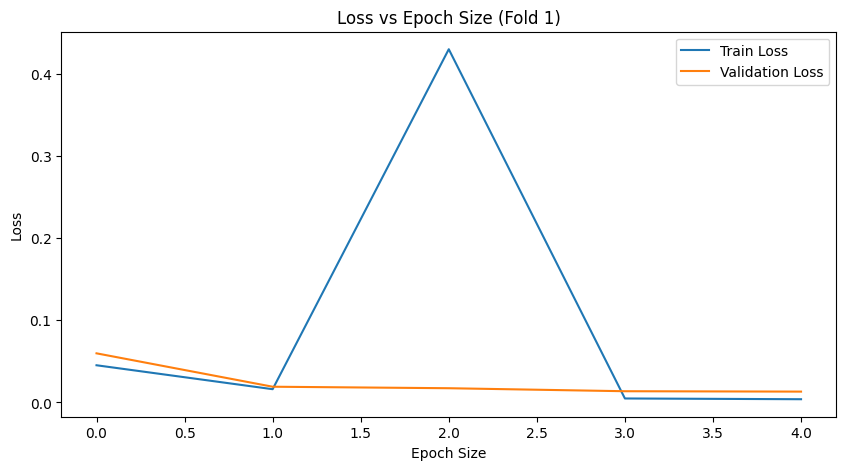

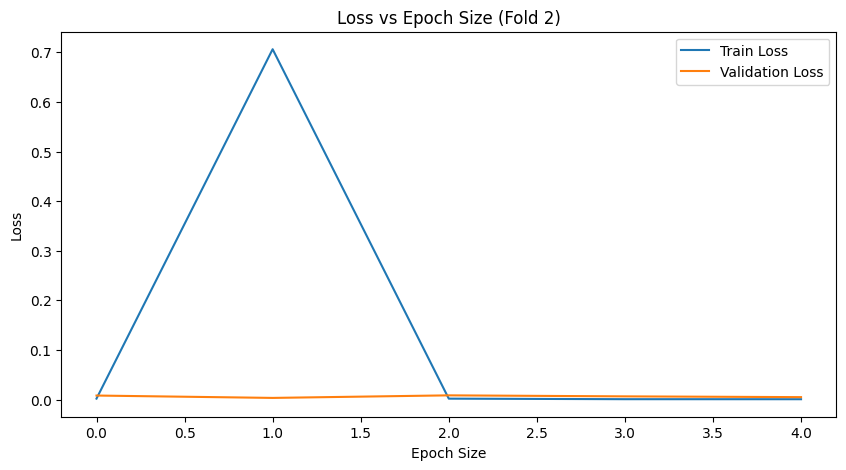

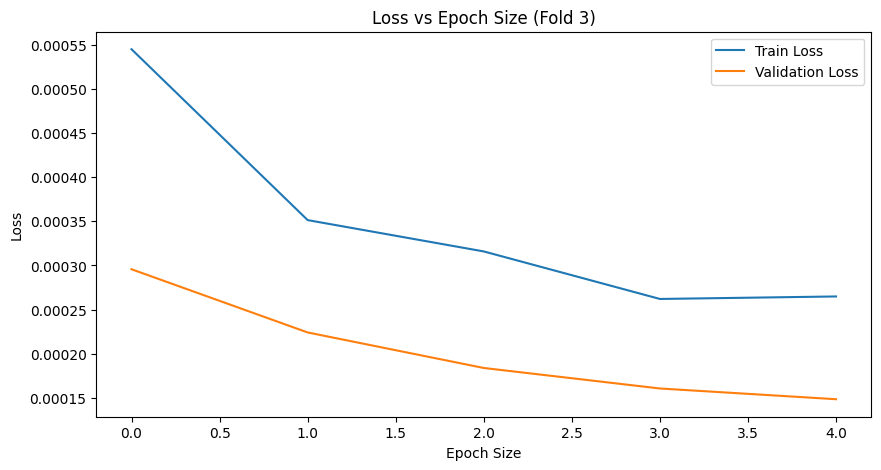

In [ ]:
# Loss GRAPH
import matplotlib.pyplot as plt

for i in range(1,4 ):
    hist_i = [entry for entry in hist if entry.get("Fold") == i]
    train_losses = [hist_i[j].get('loss') for j in range(5)]
    val_losses = [hist_i[j].get('val_loss') for j in range(5)]
    # Accuracy değerlerini alın
    train_accuracies = [hist_i[j].get('accuracy') for j in range(5)]

    # Loss vs Epoch Size grafiğini çizin
    plt.figure(figsize=(10, 5))
    plt.plot(range(5), train_losses, label='Train Loss')
    plt.plot(range(5), val_losses, label='Validation Loss')
    plt.xlabel('Epoch Size')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Epoch Size (Fold {i})')
    plt.legend()
    plt.show()


In [ ]:
avg_train_time = sum(training_times) / len(training_times)
avg_test_time = sum(testing_times) / len(testing_times)
print(f'Average Training Time: {avg_train_time:.2f} seconds')
print(f'Average Testing Time: {avg_test_time:.2f} seconds')

Average Training Time: 53.76 seconds
Average Testing Time: 58.59 seconds


In [ ]:
val_loss , predictions , true_vals = evaluate(dataloader_val)
class_predictions = np.argmax(predictions, axis=1)

report = classification_report(true_vals, class_predictions)


# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       278

    accuracy                           1.00       563
   macro avg       1.00      1.00      1.00       563
weighted avg       1.00      1.00      1.00       563

